<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/VisionDL_Lecture/Lecture4_CNNBuild_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3. CNN Build

## 1. Simple CNN

### 1.1. Library Setting

In [1]:
import numpy as np
import os, matplotlib
from matplotlib import pyplot as plt

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.2. 데이터 로딩

In [3]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data(path='minist.npz')
print(x_train.shape, y_train.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (60000,)


In [4]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


In [5]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)

y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


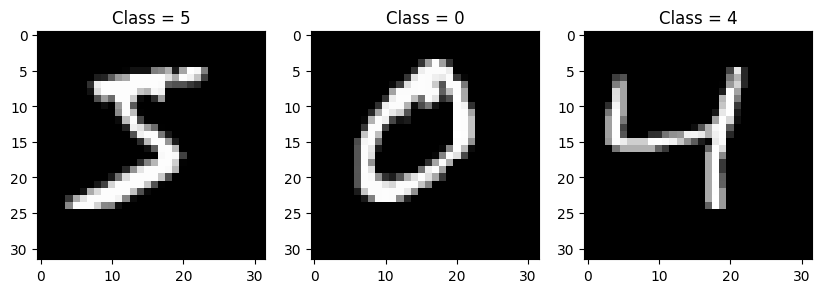

In [6]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

### 1.3. 모델 만들기

#### **AI 모델을 구성하는 레이어 만들기**

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.  
가장 대표적인 레이어 구조인 **CONV-BN-ACT-POOL** 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [7]:
first_layer = Input(shape=(32, 32, 1))

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [8]:
second_layer = layers.Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(first_layer)

다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [9]:
third_layer = layers.BatchNormalization()(second_layer)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [10]:
fourth_layer = layers.Activation('relu')(third_layer)

다음으로 이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [11]:
fifth_layer = layers.MaxPool2D(strides=(2, 2))(fourth_layer)

그 후 모든 뉴런을 일렬로 늘어세우는 Flatten 레이어를 만듭니다.

In [12]:
sixth_layer = layers.Flatten()(fifth_layer)

일렬로 늘어세운 후 이전 계층의 모든 뉴런을 연결해주는 Fully connected(Dense) 레이어를 연결합니다.

In [13]:
seventh_layer = layers.Dense(100, activation = 'relu')(sixth_layer)

Dropout 레이어를 활용해 일부 뉴런들을 무작위로 학습에서 배제하도록 합시다.

In [14]:
eighth_layer = layers.Dropout(0.25)(seventh_layer)

마지막으로 최종 결과물을 출력해주는 레이어를 만들어 줍니다.

In [15]:
final_layer =  layers.Dense(10, activation='sigmoid')(eighth_layer)

지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [16]:
model = Model(first_layer, final_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0     

### 1.4. 모델 훈련하기

신경망 모델의 손실함수와 옵티마이저, 학습률 등의 파라미터를 지정해줍니다.

성능은 정확도를 평가할 것입니다.

In [17]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-4), metrics=['accuracy'])

In [18]:
history = model.fit(x_train1, y_train1, epochs=20, batch_size=32,
                    validation_data=(x_test1, y_test1), shuffle=True)

Epoch 1/20
32/32 [==============================] - 11s 16ms/step - loss: 1.2923 - accuracy: 0.6120 - val_loss: 0.6201 - val_accuracy: 0.8120
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.4591 - accuracy: 0.8520 - val_loss: 0.4263 - val_accuracy: 0.8720
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2966 - accuracy: 0.8980 - val_loss: 0.3418 - val_accuracy: 0.8940
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1706 - accuracy: 0.9510 - val_loss: 0.3764 - val_accuracy: 0.8920
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1530 - accuracy: 0.9610 - val_loss: 0.3201 - val_accuracy: 0.9060
Epoch 6/20
32/32 [==============================] - 0s 8ms/step - loss: 0.0908 - accuracy: 0.9810 - val_loss: 0.3227 - val_accuracy: 0.9040
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9790 - val_loss: 0.3132 - val_accuracy: 0.9180
Epoch 8/20
32/32 [

### 1.5. 결과 확인하기

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [20]:
epochs = range(1,len(acc)+1)

정확도와 손실함수 그래프 그리기

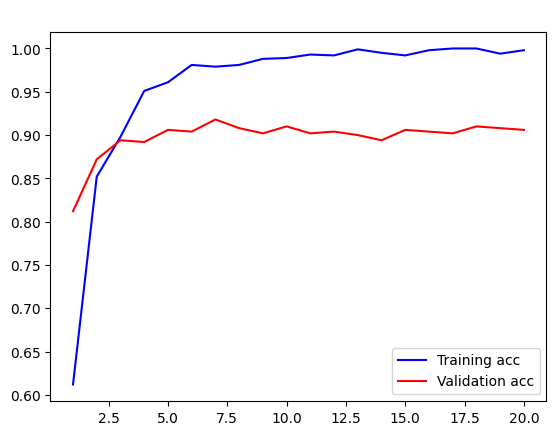

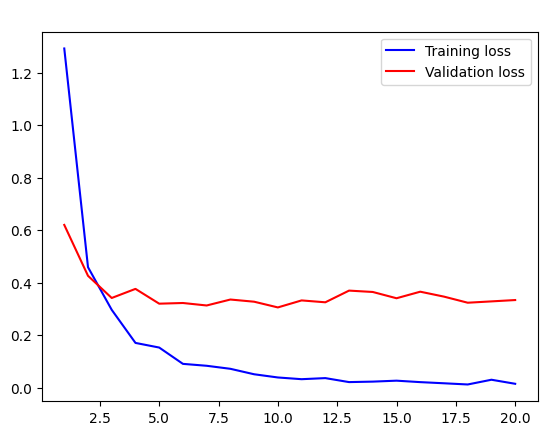

In [24]:
plt.plot(epochs, acc, c='blue', label='Training acc')
plt.plot(epochs, val_acc, c='red', label='Validation acc')
plt.title('Training and validation accuracy', color='w')
plt.legend()

plt.figure()

plt.plot(epochs, loss, c='blue', label='Training loss')
plt.plot(epochs, val_loss, c='red', label='Validation loss')
plt.title('Training and validation loss', color='w')
plt.legend()

plt.show()

* 학습 결과 추론하기

(32, 32, 1)


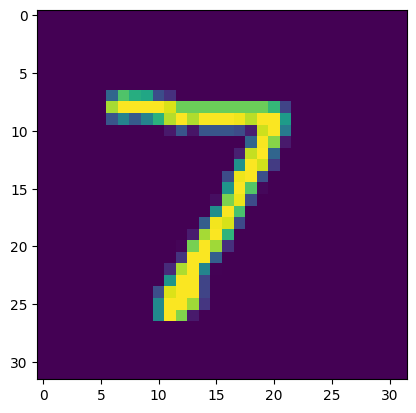

In [25]:
test1 = x_test1[0]
print(test1.shape)
plt.imshow(test1[...,0])

In [26]:
testp = x_test1[:100]
testg = y_test[:100]
scores = model.predict(testp)

new_scores = []
for score in scores:
  max_val = np.max(score)
  prob_num = list(score).index(max_val)
  new_scores.append(prob_num)

4/4 [==============================] - 0s 16ms/step


label=7, predict=7
[5.4540947e-02 1.5438711e-05 7.1780729e-01 1.2682247e-01 5.7569332e-04
 6.6017371e-04 2.1627839e-03 1.0000000e+00 1.0290889e-01 3.9739832e-01]


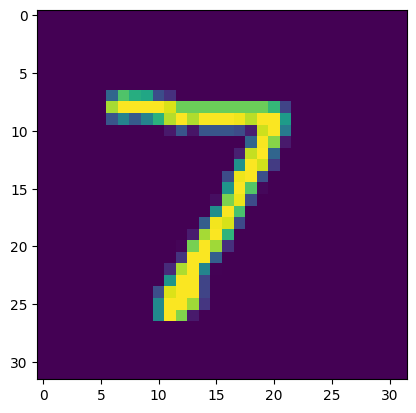

In [27]:
plt.imshow(testp[0,...,0])
print(f'label={testg[0]}, predict={new_scores[0]}')
print(scores[0])

## 2. VGG

### 2.1. Data Setting

In [28]:
from skimage import morphology
from skimage import measure
from skimage import exposure
from skimage import transform as skit

In [29]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    x_train_list.append(skit.resize(i_, (32, 32)))
for i, i_ in enumerate(x_test[:500]):
    x_test_list.append(skit.resize(i_, (32, 32)))

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


In [30]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)

y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


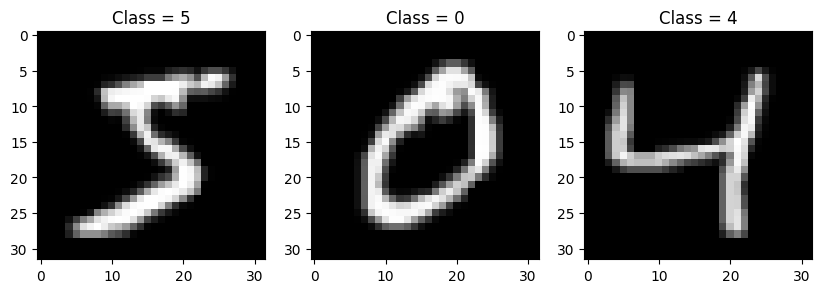

In [31]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

### 2.2. Model Build

* 2.2.1. VGG code

In [32]:
def conv_block_2d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filter_num, conv_size, activation=None, padding='same',
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def output_block(lr_dense, block_num, dens_count, act_func, drop_rate):
    lr_dense = layers.Flatten(name='flatten_layer')(lr_dense)
    for i in range(block_num):
        lr_dense = layers.Dense(dens_count[i], kernel_regularizer=None,
                                activation=act_func, name='classifier_dense_{}'.format(i+1))(lr_dense)
        lr_dense = layers.Dropout(drop_rate, name='classifier_dropout_{}'.format(i+1))(lr_dense)
    return lr_dense

In [33]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1), name='input_layer')
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 3, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 3, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 3, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

In [34]:
def VGG19_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1))
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size], 1)
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size], 2)
    block3 = conv_block_2d(block2, 4, [256, conv_size, conv_act, pool_size], 3)
    block4 = conv_block_2d(block3, 4, [512, conv_size, conv_act, pool_size], 4)
    block5 = conv_block_2d(block4, 4, [512, conv_size, conv_act, pool_size], 5)
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

* 2.2.2 VGG Build

In [35]:
network_param_2d = {'input_size': 32,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 10,
                     'output_act': 'softmax'}

In [36]:
model = VGG16_2D(network_param_2d)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 block1_batchnorm1 (BatchNor  (None, 32, 32, 64)       256       
 malization)                                                     
                                                                 
 block1_activ1 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_batchnorm2 (BatchNor  (None, 32, 32, 64)       256       
 malization)                                               

In [39]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

In [38]:
history = model.fit(x_train1, y_train1, epochs=20, batch_size=32,
                    validation_data=(x_test1, y_test1), shuffle=True)

Epoch 1/20
32/32 [==============================] - 16s 98ms/step - loss: 2.8434 - acc: 0.1520 - val_loss: 863.9510 - val_acc: 0.0840
Epoch 2/20
32/32 [==============================] - 1s 33ms/step - loss: 2.1151 - acc: 0.2360 - val_loss: 18.8932 - val_acc: 0.0840
Epoch 3/20
32/32 [==============================] - 1s 34ms/step - loss: 1.7832 - acc: 0.2950 - val_loss: 1.9267 - val_acc: 0.3100
Epoch 4/20
32/32 [==============================] - 1s 35ms/step - loss: 1.6078 - acc: 0.3600 - val_loss: 1.7751 - val_acc: 0.3740
Epoch 5/20
32/32 [==============================] - 1s 35ms/step - loss: 1.5589 - acc: 0.3780 - val_loss: 2.1325 - val_acc: 0.2320
Epoch 6/20
32/32 [==============================] - 1s 34ms/step - loss: 1.5502 - acc: 0.3940 - val_loss: 1.8565 - val_acc: 0.3880
Epoch 7/20
32/32 [==============================] - 1s 34ms/step - loss: 1.4066 - acc: 0.4340 - val_loss: 1.9433 - val_acc: 0.4460
Epoch 8/20
32/32 [==============================] - 1s 41ms/step - loss: 1.2752

### 2.3. Model Evaluate

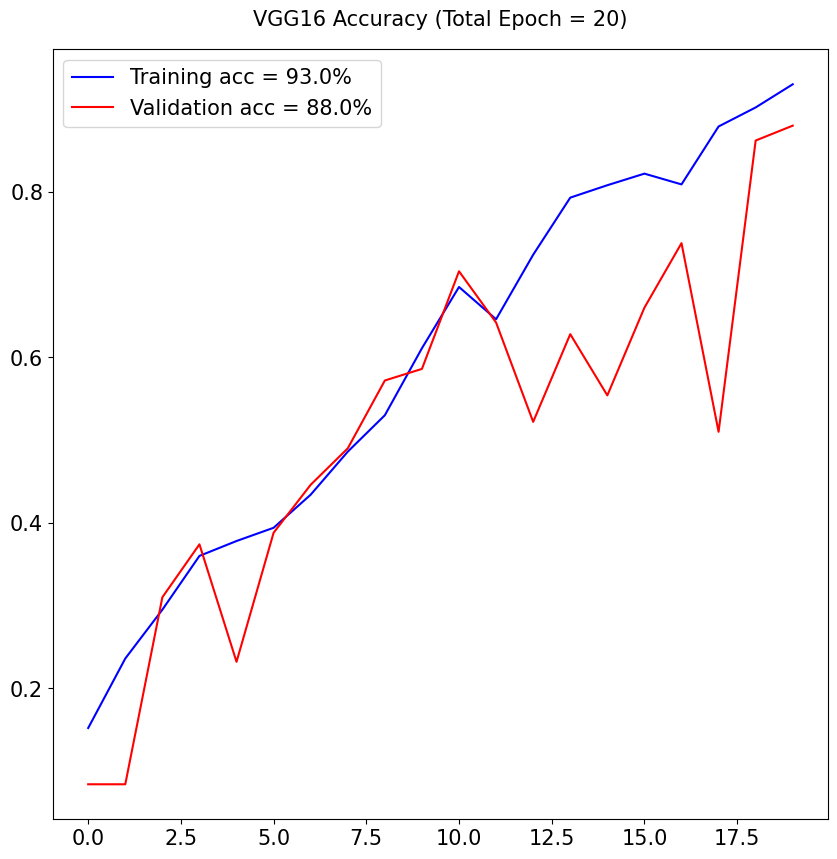

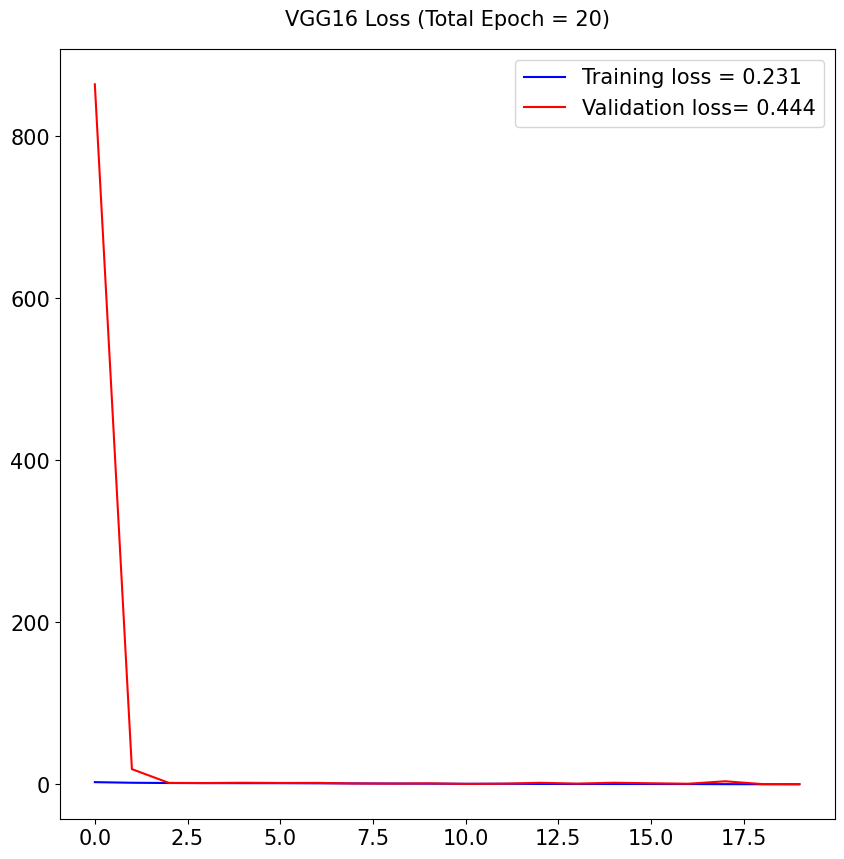

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# Accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'b', label='Training acc = {}%'.format(np.around(np.max(acc) * 100, decimals=1)))
plt.plot(epochs, val_acc, 'r', label='Validation acc = {}%'.format(np.around(np.max(val_acc) * 100, decimals=1)))
plt.title('{} Accuracy (Total Epoch = {})'.format('VGG16', len(acc)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()
# Loss graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'b', label='Training loss = {}'.format(np.around(np.min(loss), decimals=3)))
plt.plot(epochs, val_loss, 'r', label='Validation loss= {}'.format(np.around(np.min(val_loss), decimals=3)))
plt.title('{} Loss (Total Epoch = {})'.format('VGG16', len(loss)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()

### 2.4. Model Test

(32, 32, 1)


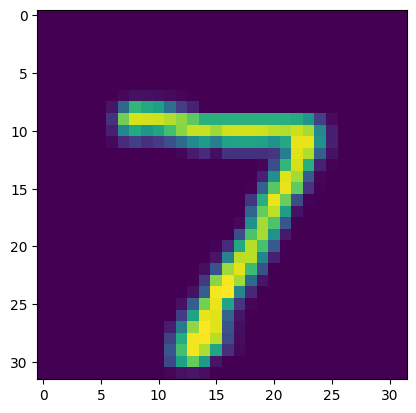

In [41]:
test1 = x_test1[0]
print(test1.shape)
plt.imshow(test1[...,0])

In [42]:
testp = x_test1[:100]
testg = y_test[:100]
scores = model.predict(testp)

new_scores = []
for score in scores:
  max_val = np.max(score)
  prob_num = list(score).index(max_val)
  new_scores.append(prob_num)

4/4 [==============================] - 1s 135ms/step


label=7, predict=7
[7.1531298e-10 6.8557536e-05 2.1760563e-06 1.4062966e-09 8.4154715e-07
 1.8811628e-08 1.2667061e-09 9.9992847e-01 5.7102323e-10 2.5557449e-08]


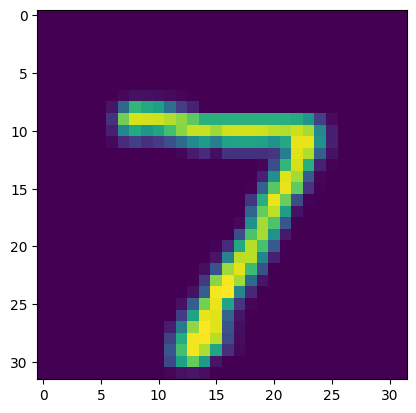

In [43]:
plt.imshow(testp[0,...,0])
print(f'label={testg[0]}, predict={new_scores[0]}')
print(scores[0])

## 3. Segmentation: FCN

https://github.com/Pulsar-kkaturi/DL-Education/blob/master/Notebooks/CNN_FCN_Build.ipynb